In [18]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss
from models.attention_gru import AttentionGRU
import gc

In [19]:
paths = ["../datasets/btc-2024-11-25.csv",
        "../datasets/btc-2024-11-24.csv",
        "../datasets/btc-2024-11-23.csv",
        "../datasets/btc-2024-11-22.csv",
        "../datasets/btc-2024-11-21.csv"]

data_df = pd.DataFrame()
for path in paths:
    data_df = pd.concat([data_df, pd.read_csv(path, sep="|")])




# train_path = "../datasets/btc-2024-11-24.csv"
# test_path = "../datasets/btc-2024-11-25.csv"
# # train_path = "/pool/btcavax/binance-usdtfutures/depth-25/btc/2024-11-24.csv"
# # test_path = "/pool/btcavax/binance-usdtfutures/depth-25/btc/2024-11-25.csv"

# df1 = pd.read_csv(train_path, sep="|")
# df2 = pd.read_csv(test_path, sep="|")

# data_df = pd.concat([df1, df2])
# del df1
# del df2

In [20]:
split_idx = int(len(data_df) * 0.8)
train_df = data_df.iloc[:split_idx].copy()
test_df = data_df.iloc[split_idx:].copy()

In [21]:
for dataset in [train_df, test_df]:
    dataset["datetime"] = pd.to_datetime(dataset["time"], unit="us")
    dataset.set_index("datetime", inplace=True)

    dataset["ofi"] = (dataset["bid_0_price"].diff() > 0) * dataset["bid_0_size"] \
        - (dataset["bid_0_price"].diff() < 0) * dataset["bid_0_size"].shift(1) \
        + (dataset["ask_0_price"].diff() < 0) * dataset["ask_0_size"] \
        - (dataset["ask_0_price"].diff() > 0) * dataset["ask_0_size"].shift(1)

agg_dict = {key: "last" for key in train_df.columns}
agg_dict["ofi"] = "sum"

train_df = train_df.resample("5min").agg(agg_dict).ffill() # there are some seconds where no updates occur
test_df = test_df.resample("5min").agg(agg_dict).ffill()

In [22]:
import itertools
for dataset in [train_df, test_df]:
    dataset["midprice"] = (dataset["bid_0_price"] + dataset["ask_0_price"]) / 2
    dataset["bid_volume"] = dataset[[f"bid_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["ask_volume"] = dataset[[f"ask_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["total_volume"] = dataset["bid_volume"] + dataset["ask_volume"]
    dataset["spread"] = (dataset["ask_0_price"] - dataset["bid_0_price"]) / dataset["ask_0_price"]
    dataset["log_return"] = np.log(dataset["midprice"]) - np.log(dataset["midprice"].shift(1))
    dataset["ob_imb"] = (dataset["bid_volume"] - dataset["ask_volume"]) / (dataset["total_volume"])
    dataset["vwap"] = (dataset["midprice"] * dataset["total_volume"]).cumsum() / dataset["total_volume"].cumsum()

    dataset["target_log_return"] = dataset["log_return"].shift(-1)
    
lagged_features = ["log_return", "vwap", "spread", "midprice"]
lagged_col_names = []

for (dataset, lag, feature) in itertools.product([train_df, test_df], [1, 10, 60], lagged_features):
    dataset[f"{feature}_lag_{lag}"] = dataset[feature].shift(lag)
    lagged_col_names.append(f"{feature}_lag_{lag}")

for dataset in [train_df, test_df]:
    dataset.dropna(inplace=True)

In [23]:
feature_cols = ["midprice", "bid_volume", "ask_volume", "total_volume", "spread", "log_return", "ob_imb", "vwap", "ofi"] \
    + [f"bid_{i}_size" for i in range(2)] \
    + [f"bid_{i}_price" for i in range(2)] \
    + [f"ask_{i}_size" for i in range(2)] \
    + [f"ask_{i}_price" for i in range(2)] \
    + lagged_col_names

target_cols = ["target_log_return"]

In [24]:
class BtcDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [25]:
# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

In [38]:
PARAMS = {
    "sequence_length": 100,
    "hidden_dim": 128,
    "epochs": 100,
    "batch_size": 32,
    "lr": 0.0025,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
train_df

,pair,time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,...,spread_lag_1,midprice_lag_1,log_return_lag_10,vwap_lag_10,spread_lag_10,midprice_lag_10,log_return_lag_60,vwap_lag_60,spread_lag_60,midprice_lag_60
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-21 20:20:00,BTCUSDT,1.732151e+15,94725.4,361661.5772,94725.3,189.4506,94725.1,189.4502,94724.1,7862.1003,...,0.000001,94725.45,0.000000,94713.682985,0.000001,94725.45,0.004814,94567.632009,0.000001,94820.05
2024-11-21 20:40:00,BTCUSDT,1.732151e+15,94725.4,361661.5772,94725.3,189.4506,94725.1,189.4502,94724.1,7862.1003,...,0.000001,94725.45,0.000000,94713.896820,0.000001,94725.45,-0.000998,94599.017381,0.000001,94725.45
2024-11-21 21:00:00,BTCUSDT,1.732151e+15,94725.4,361661.5772,94725.3,189.4506,94725.1,189.4502,94724.1,7862.1003,...,0.000001,94725.45,0.000000,94714.103022,0.000001,94725.45,0.000000,94619.990236,0.000001,94725.45
2024-11-21 21:20:00,BTCUSDT,1.732151e+15,94725.4,361661.5772,94725.3,189.4506,94725.1,189.4502,94724.1,7862.1003,...,0.000001,94725.45,0.000000,94714.301993,0.000001,94725.45,0.000000,94634.995054,0.000001,94725.45
2024-11-21 21:40:00,BTCUSDT,1.732151e+15,94725.4,361661.5772,94725.3,189.4506,94725.1,189.4502,94724.1,7862.1003,...,0.000001,94725.45,0.000000,94714.494106,0.000001,94725.45,0.000000,94646.261935,0.000001,94725.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25 22:00:00,BTCUSDT,1.732573e+15,93864.0,96304.4640,93863.9,5819.5618,93863.2,187.7264,93863.1,1032.4941,...,0.000001,93839.95,-0.001052,97838.580199,0.000001,95210.35,0.003926,97888.325614,0.000001,97639.85
2024-11-25 22:20:00,BTCUSDT,1.732574e+15,93098.0,18898.8940,93097.1,1582.6507,93096.3,186.1926,93093.3,186.1866,...,0.000001,93864.05,-0.001788,97832.788818,0.000001,95040.25,-0.001784,97887.371841,0.000001,97465.85
2024-11-25 22:40:00,BTCUSDT,1.732576e+15,94479.0,131514.7680,94478.5,188.9570,94476.4,188.9528,94476.3,30137.9397,...,0.000001,93098.05,-0.003103,97820.621682,0.000001,94745.75,-0.000530,97886.369838,0.000001,97414.25


In [27]:
train_features_df = train_df[feature_cols]
train_targets_df = train_df[target_cols]

test_features_df = test_df[feature_cols]
test_targets_df = test_df[target_cols]

train_features = torch.tensor(train_features_df.values, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets_df.values, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features_df.values, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets_df.values, dtype=torch.float32).to(device)

train_features, train_targets = create_sequences(train_features, train_targets, PARAMS["sequence_length"])
test_features, test_targets = create_sequences(test_features, test_targets, PARAMS["sequence_length"])

In [28]:
train_dataset = BtcDataset(train_features, train_targets)
test_dataset = BtcDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=PARAMS["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=False)

In [ ]:
gru_model = GRU(input_size=len(feature_cols), hidden_size=PARAMS["hidden_dim"], output_size=len(target_cols), device=device).to(device)
criterion = HybridLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    gru_model.train()  # Set the gru_model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()

        optimizer.zero_grad()

        outputs = gru_model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{PARAMS["epochs"]}, Training Loss: {avg_train_loss:.4f}")

In [ ]:
attention_gru = AttentionGRU(len(feature_cols), PARAMS["hidden_dim"], len(feature_cols), len(target_cols), device).to(device)
criterion = HybridLoss()
optimizer = torch.optim.Adam(attention_gru.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    attention_gru.train()
    epoch_loss = 0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs, _ = attention_gru(batch_features, batch_features)
        loss = criterion(outputs[:, -1, :], batch_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += loss.item()
    print(f"epoch: {epoch+1}, loss: {epoch_loss/len(train_loader)}")

epoch: 1, loss: 0.5267005778849125
epoch: 2, loss: 0.5083886824548245
epoch: 3, loss: 0.47305573970079423
epoch: 4, loss: 0.47734551802277564
epoch: 5, loss: 0.4662005640566349
epoch: 6, loss: 0.4649901509284973
epoch: 7, loss: 0.45981660336256025
epoch: 8, loss: 0.45758021697402
epoch: 9, loss: 0.45473531261086464
epoch: 10, loss: 0.45382623970508573
epoch: 11, loss: 0.44993823021650314
epoch: 12, loss: 0.45327096730470656
epoch: 13, loss: 0.4463738910853863
epoch: 14, loss: 0.4539507575333118
epoch: 15, loss: 0.4439077854156494
epoch: 16, loss: 0.4551189422607422
epoch: 17, loss: 0.4422003537416458
epoch: 18, loss: 0.4566552095115185
epoch: 19, loss: 0.44083752036094664
epoch: 20, loss: 0.4585105061531067
epoch: 21, loss: 0.4396556355059147
epoch: 22, loss: 0.4604764573276043
epoch: 23, loss: 0.4385816179215908
epoch: 24, loss: 0.4623596116900444
epoch: 25, loss: 0.43758764564991
epoch: 26, loss: 0.4640030823647976
epoch: 27, loss: 0.43644172996282576
epoch: 28, loss: 0.4618282690644

In [32]:
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            # Get model predictions
            # predictions = model(batch_features)
            predictions, _ = model(batch_features, batch_features)
            
            # Take the last time step predictions
            predictions = predictions[:, -1, :]

            loss = criterion(predictions, batch_targets)
            total_loss += loss.item()
            
            # Collect predictions and targets
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_predictions, all_targets, total_loss / len(test_loader)

def plot_results(y_true, y_pred, feature_name, feature_index):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

In [36]:
# Evaluate the model
predictions, targets, loss = evaluate_model(attention_gru, train_loader, device)
print("loss:", loss)

loss: 0.44739040173590183


In [37]:
corr_loss = CorrelationLoss()
corr_loss(torch.from_numpy(targets), torch.from_numpy(predictions))

tensor(0.8987)

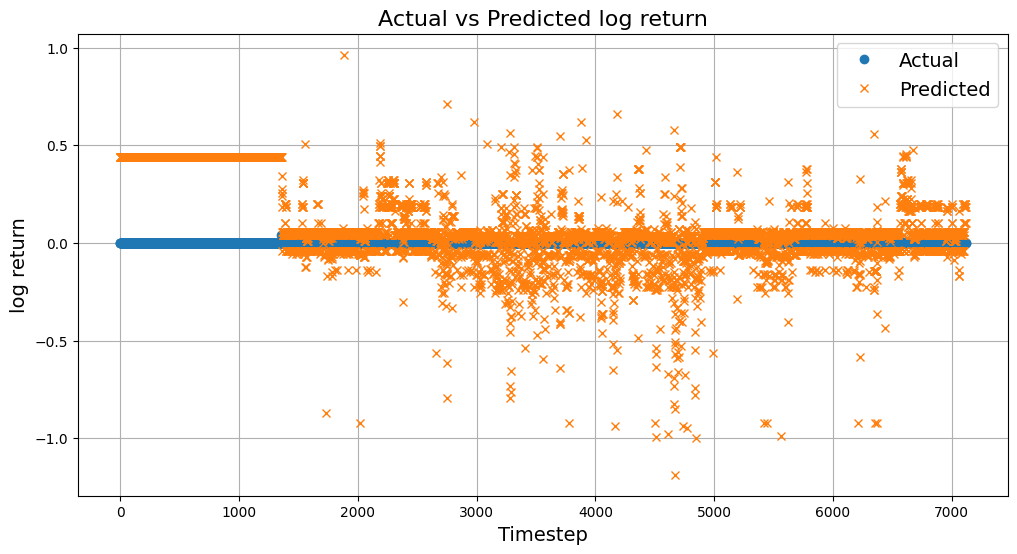

In [ ]:
plot_results(targets, predictions, "log return", 0)